In [1]:
import argparse
import os
import sys
import shutil
import datetime
import utils
from modeling.model_factory import create_model
from featurizer import HydraFeaturizer, SQLDataset
from evaluator import HydraEvaluator
import torch.utils.data as torch_data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator, Pipeline, RawField
from torchtext import datasets

/hpc/group/carin/fk43/anaconda3/envs/tfboys3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/hpc/group/carin/fk43/anaconda3/envs/tfboys3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/hpc/group/carin/fk43/anaconda3/envs/tfboys3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hpc/group/carin

In [2]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")


In [3]:
# create Field objects
SOURCE = Field(init_token = '<sos>', 
            eos_token = '<eos>', 
            tokenize = tokenizer,
            lower=True, batch_first = False)
TARGET = Field(init_token = '<sos>', 
            eos_token = '<eos>', 
            tokenize = tokenizer,
            lower=True,  batch_first = False)

# create tuples representing the columns
fields = [
  ('SQL', SOURCE),
  ('text', TARGET),
]

# load the dataset in json format
train_ds, valid_ds, test_ds = TabularDataset.splits(
   path = './',
   train = 'train_sql_text.csv',
   validation = 'dev_sql_text.csv',
   test = 'test_sql_text.csv',
   format = 'csv',
   fields = fields,
   skip_header = True
)

# check an example
print(vars(train_ds[0]))

{'SQL': ['select', 'notes', 'from', 'table', 'where', 'current', 'slogan', '=', 'south', 'australia'], 'text': ['<sos>', 'tell', 'me', 'what', 'the', 'notes', 'are', 'for', 'south', 'australia', '<eos>']}


In [4]:
SOURCE.build_vocab(train_ds, min_freq = 25)
TARGET.build_vocab(train_ds, min_freq = 25)

In [5]:
# determine what device to use
device = torch.device(
  'cuda' if torch.cuda.is_available() else 'cpu'
)
#device = "cpu"
# create iterators for train/valid/test datasets
train_it, valid_it, test_it = BucketIterator.splits(
  (train_ds, valid_ds, test_ds),
  sort_key = lambda x: len(x.SQL),
  sort = False,
  batch_size = 128,
  device = device
)

# iterate over training
for batch in train_it:
    break

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc_hidden = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.fc_cell = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc_hidden(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        cell = torch.tanh(self.fc_cell(torch.cat((cell[-2,:,:], cell[-1,:,:]), dim = 1)))
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, (hidden, cell)

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #cell = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), cell.unsqueeze(0)))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, (hidden.squeeze(0), cell.squeeze(0)), a.squeeze(1)
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, (hidden, cell) = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, (hidden, cell) = self.decoder(input, hidden, cell, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


INPUT_DIM = len(SOURCE.vocab)
OUTPUT_DIM = len(TARGET.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [8]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1464, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc_hidden): Linear(in_features=1024, out_features=512, bias=True)
    (fc_cell): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(1621, 256)
    (rnn): LSTM(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=1621, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,361,301 trainable parameters


In [10]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.SQL
        trg = batch.text
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.SQL
            trg = batch.text

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [11]:
TRG_PAD_IDX = TARGET.vocab.stoi[TARGET.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [12]:
LEARNING_RATE = 0.0005
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [42]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_it, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_it, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/datacommons/carin/fk43/CS590/models/LSTM-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 39s
	Train Loss: 3.433 | Train PPL:  30.960
	 Val. Loss: 3.500 |  Val. PPL:  33.107
Epoch: 02 | Time: 1m 36s
	Train Loss: 2.602 | Train PPL:  13.492
	 Val. Loss: 3.266 |  Val. PPL:  26.210
Epoch: 03 | Time: 1m 35s
	Train Loss: 2.204 | Train PPL:   9.058
	 Val. Loss: 3.202 |  Val. PPL:  24.594
Epoch: 04 | Time: 1m 34s
	Train Loss: 2.004 | Train PPL:   7.415
	 Val. Loss: 3.132 |  Val. PPL:  22.911
Epoch: 05 | Time: 1m 35s
	Train Loss: 1.835 | Train PPL:   6.266
	 Val. Loss: 3.119 |  Val. PPL:  22.614
Epoch: 06 | Time: 1m 34s
	Train Loss: 1.728 | Train PPL:   5.630
	 Val. Loss: 3.148 |  Val. PPL:  23.280
Epoch: 07 | Time: 1m 36s
	Train Loss: 1.658 | Train PPL:   5.247
	 Val. Loss: 3.156 |  Val. PPL:  23.479
Epoch: 08 | Time: 1m 36s
	Train Loss: 1.583 | Train PPL:   4.871
	 Val. Loss: 3.215 |  Val. PPL:  24.910
Epoch: 09 | Time: 1m 35s
	Train Loss: 1.524 | Train PPL:   4.589
	 Val. Loss: 3.194 |  Val. PPL:  24.381
Epoch: 10 | Time: 1m 35s
	Train Loss: 1.487 | Train PPL

In [13]:
model.load_state_dict(torch.load('/datacommons/carin/fk43/CS590/models/LSTM-model.pt'))


<All keys matched successfully>

In [14]:

test_loss = evaluate(model, test_it, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

ValueError: too many values to unpack (expected 2)

In [15]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        

    tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])

    with torch.no_grad():
        encoder_outputs, (hidden, cell) = model.encoder(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, (hidden, cell), attention = model.decoder(trg_tensor, hidden, cell, encoder_outputs)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [16]:
from matplotlib import pyplot as plt 
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [17]:
example_idx = 12

src = vars(train_ds.examples[example_idx])['SQL']
trg = vars(train_ds.examples[example_idx])['text']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['select', 'school/club', 'team', 'from', 'table', 'where', 'no', '.', '=', '6']
trg = ['<sos>', 'what', 'school', 'did', 'player', 'number', '6', 'come', 'from', '?', '<eos>']


In [18]:
translation, attention = translate_sentence(src, SOURCE, TARGET, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['<sos>', 'what', 'is', 'the', 'team', 'of', '6', '.', '6', '?', '<eos>']


/hpc/group/carin/fk43/anaconda3/envs/tfboys3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/hpc/group/carin/fk43/anaconda3/envs/tfboys3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


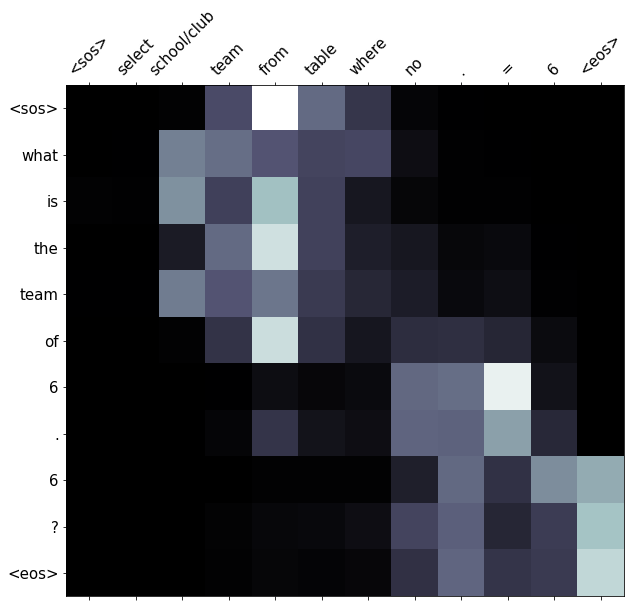

In [19]:

display_attention(src, translation, attention)


In [25]:
agg_ops = ['', 'MAX', 'MIN', 'COUNT', 'SUM', 'AVG']
cond_ops = ['=', '>', '<', 'OP']
syms = ['SELECT', 'WHERE', 'AND', 'COL', 'TABLE', 'CAPTION', 'PAGE', 'SECTION', 'OP', 'COND', 'QUESTION', 'AGG', 'AGGOPS', 'CONDOPS']

all_sql_syms = agg_ops + cond_ops + syms
all_sql_syms = [e_sym.lower() for e_sym in all_sql_syms]

def post_copy_processing(src, pred, attention):
    unk_locs = np.where(np.asarray(pred) == '<unk>')[0]
    refined_sentence = copy.deepcopy(pred)
    exclude_idx = np.isin(np.asarray(src), np.asarray(all_sql_syms))
    excluded_src = np.asarray(src)[~exclude_idx]
    excluded_attention = attention[:, ~exclude_idx]

    for e_unk_idx in unk_locs:
        this_unk_attention = excluded_attention[e_unk_idx, :]
        best_matched_inp_idx = this_unk_attention.argmax().cpu().data.numpy()
        best_matched_inp = excluded_src[best_matched_inp_idx]
        refined_sentence[e_unk_idx] = best_matched_inp
        # set already matched to -inf
        excluded_attention[:, best_matched_inp_idx] = 0
    return ' '.join(refined_sentence)

In [23]:
attention.shape

torch.Size([13, 1, 11])

In [35]:
import copy
import tqdm 

myfile = open('LSTM-sql2text_results_on_test_set2.txt', 'w')

show_num_of_sample = 200
src_field = SOURCE
trg_field = TARGET
model.eval()  
with torch.no_grad():
    for i, sample in tqdm.tqdm(enumerate(test_ds)):

        src = sample.SQL
        trg = sample.text
        pred_text, attention = translate_sentence(src, src_field, trg_field, model, device, max_len=100)
        pred_text = post_copy_processing(src, pred_text[1:-1], attention[1:-1, 0, 1:-1])
        ref_text = ' '.join(np.asarray(TARGET.vocab.itos)[[TARGET.vocab.stoi[e_word] for e_word in trg]])
        #print(f'Referenced trg = {ref_text}')        
        sql = ' '.join(src)
        ref_text = ' '.join(trg[1:-1])
#         print('-'*10 + 'Example {}'.format(i+1) + '-'*10)
#         print("Original SQL: " + sql.replace('<sos>', '').replace('<eos>', ''))
#         print("Original Text: " + ref_text)
#         #print("Predicted Text: " + pred_text.replace('<sos>', '').replace('<eos>', ''))
#         print("Predicted Pred:" + pred_text.replace('<sos>', '').replace('<eos>', ''))
#         print('   ')
        line_1 = '-'*10 + 'Example {}'.format(i+1) + '-'*10
        line_2 = "Original SQL: " + sql.replace('<sos>', '').replace('<eos>', '')
        line_3 = "Original Text: " + ref_text
        line_4 = "Predicted Pred:" + pred_text.replace('<sos>', '').replace('<eos>', '')
        myfile.write("%s\n" % line_1)
        myfile.write("%s\n" % line_2)
        myfile.write("%s\n" % line_3)
        myfile.write("%s\n" % line_4)
        myfile.write("%s\n" % '    ')
myfile.close()


15878it [03:18, 80.17it/s]


In [86]:
pred_text 

['<sos>',
 'what',
 'is',
 'the',
 'nationality',
 'of',
 '<unk>',
 '<unk>',
 'from',
 '<unk>',
 '<unk>',
 '?',
 '<eos>']